# Sustained Phonation Feature Extraction Notebook
In this iPython Notebook, we'll show you how to use
our implementation of the features used in <paper citation>
to extract them on your own dataset.

To follow this tutorial, you'll need some audio files to run our
feature extractors on. Ideally, these audio samples each
contain a recording of someone speaking the vowel /a/ for a few seconds.

## Step 1: Loading your audio samples

In this part of the notebook, we load the audio samples,
the goal is to have them all as Numpy arrays. We'll store them in
a list of `AudioSample` objects which just stores the PCM array,
its sampling rate, and and a string identifier for the sample.

In this example, we suppose that all the audio samples are read from
single WAV files in a folder.

In [1]:
from features import AudioSample
from pathlib import Path
import pandas as pd
from typing import List
import librosa
import numpy as np
samples_folder = Path('example_sound/')
audio_samples: List[AudioSample] = []
for wav_file in samples_folder.iterdir():
    if not wav_file.suffix == ".wav":
        continue
    else:
        audio_array, rate = librosa.core.load(str(wav_file), sr=44100)
        audio_samples.append(AudioSample(data=audio_array,
                                         rate=rate,
                                         name=wav_file.name))

## Step 2: Configure the feature extractors

In this step, you can tweak, remove of add feature extractors.
Here we've put all the feature extractors from our paper 2020 Interspeech paper ['Vocal markers from sustained phonation in Huntington’s Disease'](https://arxiv.org/abs/2006.05365).

All of their actual implementations are kept in the `features` module contained
in this repository.

In [2]:
from typing import Dict

print('The DFA and RPDE are not computed by default.')
from features import *
compute_dfa_rpde = False
features_dict: Dict[str, SampleProcessor] = {
    "Maximum_phonation_time":MPT(),
    'Maximum_phonation_time_until_voice_break':MaximumPhonationUntilVoiceBreak(),
    'Aperiodicity_Features':AperiodicityFeatures(),
    'MFCCs_Mean_Of_Std':MFCCsMeanOfStd(),
    "hnr": PraatHNR(),
    "tremor": VocalTremorFeatures(),
    "signal_perturbation": PraatVoiceFeatures(),
    "mps": ModulationPowerSpectrumAnalysis(),
    "f0_stats" : FundamentalFrequency(method='shennong'),
}
if compute_dfa_rpde:
    features_dict["rpde"]= RPDE(dim=4, tau=35, epsilon=0.12, tmax=5000)
    features_dict["dfa"]= DFA(scale_boundaries=(1.259, 1.559), scale_density=0.03)

The DFA and RPDE are not computed by default.


## Step 3: Build and run the extraction

We'll define here a helper function that runs the extraction using the samples
and the selected feature extractors (or processors). Then, we'll run
that function on our audio samples dataset.

Once the feature extraction is complete, all the features computed for all the
samples should be stored in dictionary. We format the classical phonatory features in a final dataframe `classic_phonatory_features_df`.

In [3]:
from collections import defaultdict
import tqdm

def extract(samples_list: List[AudioSample],
          features: Dict[str, SampleProcessor],
          fail_on_error: bool = True):
    """This function takes care of running the extraction,
    and stores the extracted features for each sample in a neat
    little dictionnary"""
    extracted_features = defaultdict(dict)
    for feature_name, processor in features.items():
        for audio_sample in tqdm.tqdm(samples_list):
            try:
                proc_output = processor(audio_sample)
            except Exception as e:
                if fail_on_error:
                    raise e
                else:
                    print(f"Got error on sample '{audio_sample.name}':' "
                          f"{type(e).__name__} :{str(e)}', skipping.")
            else:
                # maybe we should use tuples for the dict keys?
                extracted_features[audio_sample.name][feature_name] = proc_output

    return extracted_features



In [4]:
# then, we run the extraction.
# WARNING: this may (and should) take some time if DFA and RPDE are included.
extracted_features = extract(audio_samples, features_dict, fail_on_error=True)

100%|██████████| 5/5 [00:01<00:00,  4.70it/s]


In [5]:
# Formatting the features
for file_name in extracted_features.keys():
    extracted_features[file_name]['Fraction of locally unvoiced frames'] = extracted_features[file_name]['Aperiodicity_Features']['Fraction of locally unvoiced frames']
    extracted_features[file_name]['Number of voice breaks'] = extracted_features[file_name]['Aperiodicity_Features']['Number of voice breaks']
    extracted_features[file_name]['Degree of voice breaks'] = extracted_features[file_name]['Aperiodicity_Features']['Degree of voice breaks']
    extracted_features[file_name]['Mean_Of_Std_mfcc'] = extracted_features[file_name]['MFCCs_Mean_Of_Std']['mfcc']
    extracted_features[file_name]['Mean_Of_Std_delta_mfcc'] = extracted_features[file_name]['MFCCs_Mean_Of_Std']['delta_mfcc']
    extracted_features[file_name]['frequency tremor intensity index (FTrI)'] = extracted_features[file_name]['tremor']['frequency tremor intensity index (FTrI)']
    extracted_features[file_name]['amplitude tremor intensity index (ATrI)'] = extracted_features[file_name]['tremor']['amplitude tremor intensity index (ATrI)']
    extracted_features[file_name]['jitter'] = extracted_features[file_name]['signal_perturbation']['jitter']['local']
    extracted_features[file_name]['shimmer'] = extracted_features[file_name]['signal_perturbation']['shimmer']['local']
    extracted_features[file_name]['F0_Std'] = np.std(extracted_features[file_name]['f0_stats'])

airflow_features_names = ['Maximum_phonation_time','Maximum_phonation_time_until_voice_break']
aperiodicity_features_names = ['Number of voice breaks','Degree of voice breaks','Fraction of locally unvoiced frames']
signal_perturbation_features_names = ['jitter','shimmer']
if compute_dfa_rpde:
    irregular_vibration_features_names = ['F0_Std','rpde']
    increased_noise_features_names = ['hnr','dfa']
else:
    irregular_vibration_features_names = ['F0_Std']
    increased_noise_features_names = ['hnr']
vocal_tremor_features_names = ['frequency tremor intensity index (FTrI)','amplitude tremor intensity index (ATrI)']
articulatory_features_names = ['Mean_Of_Std_mfcc','Mean_Of_Std_delta_mfcc']
all_features_names = airflow_features_names+aperiodicity_features_names+signal_perturbation_features_names
all_features_names += irregular_vibration_features_names+increased_noise_features_names
all_features_names += vocal_tremor_features_names+articulatory_features_names


In [6]:
classic_phonatory_features = {}
for file_name in extracted_features.keys():
    classic_phonatory_features[file_name] = {curr_feat: extracted_features[file_name][curr_feat] for curr_feat in all_features_names}

classic_phonatory_features_df = pd.DataFrame.from_dict(classic_phonatory_features,orient='index')
len(classic_phonatory_features_df.columns)

13

## Step 4 : Description and MPS visualisation 
Now, we can obtain some description of the dataset and visualise the Modulation Power Spectrum features

In [7]:
classic_phonatory_features_df.describe()

,Maximum_phonation_time,Maximum_phonation_time_until_voice_break,Number of voice breaks,Degree of voice breaks,Fraction of locally unvoiced frames,jitter,shimmer,F0_Std,hnr,frequency tremor intensity index (FTrI),amplitude tremor intensity index (ATrI),Mean_Of_Std_mfcc,Mean_Of_Std_delta_mfcc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.000000,5.00000,5.000000,5.000000
mean,12.029061,5.673669,3.000000,3.223400,8.963200,0.006281,0.070812,21.604178,15.761006,6.428500,25.54940,7.251858,1.238376
std,4.303302,5.649126,4.636809,5.975897,4.297089,0.002058,0.029557,28.267693,5.024811,5.323764,3.89228,1.067679,0.088678
min,6.652517,0.300000,0.000000,0.000000,4.209000,0.003603,0.034545,3.090616,7.238912,2.694000,21.57700,6.417114,1.124982
25%,9.260408,0.300000,0.000000,0.000000,6.798000,0.005233,0.059730,3.672771,16.570320,3.894750,21.66300,6.613118,1.179904
50%,12.553696,6.652517,1.000000,0.425000,7.151000,0.006411,0.067890,10.215859,16.761564,4.346000,26.47800,6.754651,1.238235
75%,13.815828,7.300000,3.000000,1.867000,11.722000,0.007037,0.076147,20.438389,17.670435,6.879750,27.45900,7.441609,1.310514
max,17.862857,13.815828,11.000000,13.825000,14.936000,0.009123,0.115750,70.603256,20.563798,14.328000,30.57000,9.032798,1.338245


In [8]:
import matplotlib.pyplot as plt

def plot_mps(mps,wt,wf, DBNOISE=50):
    plt.figure()
    plt.clf()
    cmap = plt.get_cmap('jet')
    ex = (wt.min(), wt.max(), wf.min() * 1e3,
          wf.max() * 1e3)
    logMPS = 10.0 * np.log10(mps)
    maxMPS = logMPS.max()
    minMPS = maxMPS - DBNOISE
    logMPS[logMPS < minMPS] = minMPS
    plt.imshow(
        logMPS,
        interpolation='nearest',
        aspect='auto',
        origin='lower',
        cmap=cmap,
        extent=ex)
    plt.ylabel('Spectral Frequency (Cycles/KHz)')
    plt.xlabel('Temporal Frequency (Hz)')
    plt.colorbar()
    plt.ylim((0, wf.max() * 1e3))
    plt.title('Modulation Power Spectrum')
    plt.show()


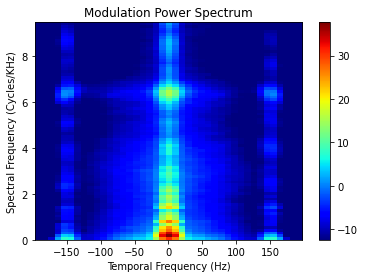

In [9]:
file_name = 'aaa_maureen.wav'
plot_mps(extracted_features[file_name]['mps']['mps'], extracted_features[file_name]['mps']['mps_wt'],extracted_features[file_name]['mps']['mps_wf'])



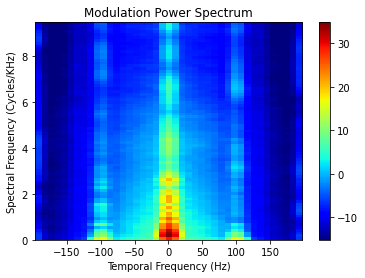

In [10]:
file_name = 'ah_mathieu.wav'
plot_mps(extracted_features[file_name]['mps']['mps'], extracted_features[file_name]['mps']['mps_wt'],extracted_features[file_name]['mps']['mps_wf'])
